In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

from pytorch_forecasting import GroupNormalizer, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.metrics import MAE, RMSE, SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
from pytorch_forecasting.utils import profile
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

In [47]:
from datetime import datetime, timedelta

In [48]:
def get_start_end_dates(year, week):
    d = datetime(year,1,1)
    if(d.weekday()<= 3):
        d = d - timedelta(d.weekday())             
    else:
        d = d + timedelta(7-d.weekday())
    dlt = timedelta(days = (week-1)*7)
    return (d + dlt,  d + dlt + timedelta(days=6))

In [46]:
def get_week_of_month(date):
   first_day = date.replace(day=1)

   day_of_month = date.day

   if(first_day.weekday() == 6):
       adjusted_dom = (1 + first_day.weekday()) / 7
   else:
       adjusted_dom = day_of_month + first_day.weekday()

   return int(ceil(adjusted_dom/7.0))

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

In [3]:
def standard_column_names(df_pd):
      """
      Funtion to standardize column names Upper case the names, Replace spaces with underscore
      (,) with blanks,% with PER and - with undescore
      df: Input dataframe
      df_pd: Output with Standardzied column names
      """
      #df_pd=df.toPandas()
      df_pd.columns = df_pd.columns.str.strip().str.upper().str.replace(' ', '_').str.replace('(', '').str.replace(')', '').str.replace('%', 'PER').str.replace('-', '_')
      return df_pd

## Read Feature Engineeried Data

In [4]:
df_data=pd.read_csv(r'C:\Users\kishor.kukreja\OneDrive - Fractal Analytics Pvt. Ltd\Desktop\WIP\Tech Challenge\Output\data_with_feature_engineering.csv')

In [6]:
df_data['key']=df_data.apply(lambda x : x['product_id']+x['channel']+x['country'],axis=1)

In [7]:
df_xx=df_data.groupby(['key','product_id', 'channel', 'country'])['sales_volume'].sum().reset_index()

In [8]:
remove_items=list(df_xx[df_xx['sales_volume']==0]['key'].unique())

In [13]:
df_filtered=df_data[~df_data['key'].isin(remove_items)]
df_filtered.shape

(111660, 40)

In [15]:
df_data=df_filtered.copy()

In [16]:
df_data.head()

,product_id,channel,country,week_key,current_price_x,sales_volume,total_stock_volume,store_stock_volume,depot_stock_volume,future_commitment_volume,intake_volume,per_stores_with_stock_count,per_stores_with_sales_count,week,year,start_date,end_date,product_season,product_group,product_subgroup,product_class,product_subclass,original_price,previous_price,current_price_y,week_sin365_1,week_cos365_1,week_sin365_2,week_cos365_2,price_change_wrt_previous,price_change_wrt_original,week_of_month,is_month_start,is_month_end,month,is_year_start,is_year_end,is_quarter_start,is_quarter_end,key
0,135fc45e,Stores,B,201502,18.98,3.0,39.0,6.0,33.0,0.0,0.0,0.1010,0.0078,2,2015,2015-01-05,2015-01-11,L,26387251,c3567a18,8face522,641d430c,18.98,18.98,16.28,0.239316,0.970942,0.464723,0.885456,0.0,0.0,2,0,0,1,0,0,0,0,135fc45eStoresB
1,135fc45e,Stores,B,201503,18.98,3.0,38.0,6.0,33.0,0.0,-1.0,0.1010,0.0078,3,2015,2015-01-12,2015-01-18,L,26387251,c3567a18,8face522,641d430c,18.98,18.98,16.28,0.354605,0.935016,0.663123,0.748511,0.0,0.0,3,0,0,1,0,0,0,0,135fc45eStoresB
2,135fc45e,Stores,B,201504,18.98,3.0,38.0,6.0,33.0,0.0,-1.0,0.1010,0.0078,4,2015,2015-01-19,2015-01-25,L,26387251,c3567a18,8face522,641d430c,18.98,18.98,16.28,0.464723,0.885456,0.822984,0.568065,0.0,0.0,4,0,1,1,0,0,0,0,135fc45eStoresB
3,135fc45e,Stores,B,201505,18.98,4.0,38.0,6.0,32.0,0.0,0.0,0.1127,0.0117,5,2015,2015-01-26,2015-02-01,L,26387251,c3567a18,8face522,641d430c,18.98,18.98,16.28,0.568065,0.822984,0.935016,0.354605,0.0,0.0,5,0,1,1,0,0,0,0,135fc45eStoresB
4,135fc45e,Stores,B,201506,18.98,4.0,38.0,5.0,32.0,0.0,1.0,0.1088,0.0117,6,2015,2015-02-02,2015-02-08,L,26387251,c3567a18,8face522,641d430c,18.98,18.98,16.28,0.663123,0.748511,0.992709,0.120537,0.0,0.0,1,1,0,2,1,0,0,0,135fc45eStoresB


In [17]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 111660 entries, 0 to 239939
Data columns (total 40 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   product_id                   111660 non-null  object 
 1   channel                      111660 non-null  object 
 2   country                      111660 non-null  object 
 3   week_key                     111660 non-null  int64  
 4   current_price_x              111660 non-null  float64
 5   sales_volume                 111660 non-null  float64
 6   total_stock_volume           111660 non-null  float64
 7   store_stock_volume           111660 non-null  float64
 8   depot_stock_volume           111660 non-null  float64
 9   future_commitment_volume     111660 non-null  float64
 10  intake_volume                111660 non-null  float64
 11  per_stores_with_stock_count  111660 non-null  float64
 12  per_stores_with_sales_count  111660 non-null  float64
 13 

In [18]:
df_data['start_date']=pd.to_datetime(df_data['start_date'])
df_data['end_date']=pd.to_datetime(df_data['end_date'])

In [19]:
### Decompose into Trend and Seasonlaity

In [20]:
df_data.columns

Index(['product_id', 'channel', 'country', 'week_key', 'current_price_x',
       'sales_volume', 'total_stock_volume', 'store_stock_volume',
       'depot_stock_volume', 'future_commitment_volume', 'intake_volume',
       'per_stores_with_stock_count', 'per_stores_with_sales_count', 'week',
       'year', 'start_date', 'end_date', 'product_season', 'product_group',
       'product_subgroup', 'product_class', 'product_subclass',
       'original_price', 'previous_price', 'current_price_y', 'week_sin365_1',
       'week_cos365_1', 'week_sin365_2', 'week_cos365_2',
       'price_change_wrt_previous', 'price_change_wrt_original',
       'week_of_month', 'is_month_start', 'is_month_end', 'month',
       'is_year_start', 'is_year_end', 'is_quarter_start', 'is_quarter_end',
       'key'],
      dtype='object')

In [21]:
groups = df_data.groupby(['product_id', 'channel', 'country'])
seasonal = {}
m = 0
for grp in groups:
    x = grp[1]
    x['start_date'] = pd.to_datetime(x['start_date'])
    #tdi = pd.DatetimeIndex(x.date)
    #x.set_index(tdi, inplace=True)
    x = x.set_index(x['week_key'])
    additional_decom = seasonal_decompose(x['sales_volume'],model = 'additive',period=int(len(x)/3.5))
    seasonal[grp[0]] = additional_decom
list_item = df_data[['product_id','channel', 'country']].drop_duplicates()

In [22]:
df_trend = pd.DataFrame(columns = ['week_key', 'product_id', 'channel', 'country' ,'trend', 'seasonality'])

for idex,row in list_item.iterrows():
    tp=(row['product_id'],row['channel'],row['country'])
    p = seasonal[tp]
    df_x = pd.DataFrame(columns = ['product_id', 'channel', 'country' ,'trend','seasonality'])
    #print(x)
    #df_x['time_id'] = p.trend.index
    
    df_x['trend'] = p.trend
    df_x['seasonality'] = p.seasonal
    df_x['trend'] = df_x['trend'].fillna(method = 'backfill')
    df_x['trend'] = df_x['trend'].fillna(method = 'ffill')
    df_x['seasonality'] = df_x['seasonality'].fillna(method = 'backfill')
    df_x['seasonality'] = df_x['seasonality'].fillna(method = 'ffill')
    df_x['product_id'] = tp[0]
    df_x['channel'] = tp[1]
    df_x['country'] = tp[2]
    df_x = df_x.reset_index()
    df_trend = pd.concat([df_trend,df_x])

In [23]:
df_model_data = pd.merge(df_data,df_trend, on = ['week_key', 'product_id', 'channel', 'country'])

In [24]:
len(df_model_data)/len(df_data)

1.0

In [25]:
df_model_data.head()

,product_id,channel,country,week_key,current_price_x,sales_volume,total_stock_volume,store_stock_volume,depot_stock_volume,future_commitment_volume,intake_volume,per_stores_with_stock_count,per_stores_with_sales_count,week,year,start_date,end_date,product_season,product_group,product_subgroup,product_class,product_subclass,original_price,previous_price,current_price_y,week_sin365_1,week_cos365_1,week_sin365_2,week_cos365_2,price_change_wrt_previous,price_change_wrt_original,week_of_month,is_month_start,is_month_end,month,is_year_start,is_year_end,is_quarter_start,is_quarter_end,key,trend,seasonality
0,135fc45e,Stores,B,201502,18.98,3.0,39.0,6.0,33.0,0.0,0.0,0.1010,0.0078,2,2015,2015-01-05,2015-01-11,L,26387251,c3567a18,8face522,641d430c,18.98,18.98,16.28,0.239316,0.970942,0.464723,0.885456,0.0,0.0,2,0,0,1,0,0,0,0,135fc45eStoresB,19.588235,-3.436563
1,135fc45e,Stores,B,201503,18.98,3.0,38.0,6.0,33.0,0.0,-1.0,0.1010,0.0078,3,2015,2015-01-12,2015-01-18,L,26387251,c3567a18,8face522,641d430c,18.98,18.98,16.28,0.354605,0.935016,0.663123,0.748511,0.0,0.0,3,0,0,1,0,0,0,0,135fc45eStoresB,19.588235,-4.583622
2,135fc45e,Stores,B,201504,18.98,3.0,38.0,6.0,33.0,0.0,-1.0,0.1010,0.0078,4,2015,2015-01-19,2015-01-25,L,26387251,c3567a18,8face522,641d430c,18.98,18.98,16.28,0.464723,0.885456,0.822984,0.568065,0.0,0.0,4,0,1,1,0,0,0,0,135fc45eStoresB,19.588235,-4.171857
3,135fc45e,Stores,B,201505,18.98,4.0,38.0,6.0,32.0,0.0,0.0,0.1127,0.0117,5,2015,2015-01-26,2015-02-01,L,26387251,c3567a18,8face522,641d430c,18.98,18.98,16.28,0.568065,0.822984,0.935016,0.354605,0.0,0.0,5,0,1,1,0,0,0,0,135fc45eStoresB,19.588235,-3.113033
4,135fc45e,Stores,B,201506,18.98,4.0,38.0,5.0,32.0,0.0,1.0,0.1088,0.0117,6,2015,2015-02-02,2015-02-08,L,26387251,c3567a18,8face522,641d430c,18.98,18.98,16.28,0.663123,0.748511,0.992709,0.120537,0.0,0.0,1,1,0,2,1,0,0,0,135fc45eStoresB,19.588235,-3.201269


In [26]:
df_model_data['rolling_week']=df_model_data.groupby(['product_id', 'channel', 'country']).week_key.rank(method='dense',ascending=True).astype(int)

In [27]:
df_model_data.head()

,product_id,channel,country,week_key,current_price_x,sales_volume,total_stock_volume,store_stock_volume,depot_stock_volume,future_commitment_volume,intake_volume,per_stores_with_stock_count,per_stores_with_sales_count,week,year,start_date,end_date,product_season,product_group,product_subgroup,product_class,product_subclass,original_price,previous_price,current_price_y,week_sin365_1,week_cos365_1,week_sin365_2,week_cos365_2,price_change_wrt_previous,price_change_wrt_original,week_of_month,is_month_start,is_month_end,month,is_year_start,is_year_end,is_quarter_start,is_quarter_end,key,trend,seasonality,rolling_week
0,135fc45e,Stores,B,201502,18.98,3.0,39.0,6.0,33.0,0.0,0.0,0.1010,0.0078,2,2015,2015-01-05,2015-01-11,L,26387251,c3567a18,8face522,641d430c,18.98,18.98,16.28,0.239316,0.970942,0.464723,0.885456,0.0,0.0,2,0,0,1,0,0,0,0,135fc45eStoresB,19.588235,-3.436563,1
1,135fc45e,Stores,B,201503,18.98,3.0,38.0,6.0,33.0,0.0,-1.0,0.1010,0.0078,3,2015,2015-01-12,2015-01-18,L,26387251,c3567a18,8face522,641d430c,18.98,18.98,16.28,0.354605,0.935016,0.663123,0.748511,0.0,0.0,3,0,0,1,0,0,0,0,135fc45eStoresB,19.588235,-4.583622,2
2,135fc45e,Stores,B,201504,18.98,3.0,38.0,6.0,33.0,0.0,-1.0,0.1010,0.0078,4,2015,2015-01-19,2015-01-25,L,26387251,c3567a18,8face522,641d430c,18.98,18.98,16.28,0.464723,0.885456,0.822984,0.568065,0.0,0.0,4,0,1,1,0,0,0,0,135fc45eStoresB,19.588235,-4.171857,3
3,135fc45e,Stores,B,201505,18.98,4.0,38.0,6.0,32.0,0.0,0.0,0.1127,0.0117,5,2015,2015-01-26,2015-02-01,L,26387251,c3567a18,8face522,641d430c,18.98,18.98,16.28,0.568065,0.822984,0.935016,0.354605,0.0,0.0,5,0,1,1,0,0,0,0,135fc45eStoresB,19.588235,-3.113033,4
4,135fc45e,Stores,B,201506,18.98,4.0,38.0,5.0,32.0,0.0,1.0,0.1088,0.0117,6,2015,2015-02-02,2015-02-08,L,26387251,c3567a18,8face522,641d430c,18.98,18.98,16.28,0.663123,0.748511,0.992709,0.120537,0.0,0.0,1,1,0,2,1,0,0,0,135fc45eStoresB,19.588235,-3.201269,5


## Train Model Using DeepAR

In [28]:
df_model_data=standard_column_names(df_model_data)
df_model_data.columns

Index(['PRODUCT_ID', 'CHANNEL', 'COUNTRY', 'WEEK_KEY', 'CURRENT_PRICE_X',
       'SALES_VOLUME', 'TOTAL_STOCK_VOLUME', 'STORE_STOCK_VOLUME',
       'DEPOT_STOCK_VOLUME', 'FUTURE_COMMITMENT_VOLUME', 'INTAKE_VOLUME',
       'PER_STORES_WITH_STOCK_COUNT', 'PER_STORES_WITH_SALES_COUNT', 'WEEK',
       'YEAR', 'START_DATE', 'END_DATE', 'PRODUCT_SEASON', 'PRODUCT_GROUP',
       'PRODUCT_SUBGROUP', 'PRODUCT_CLASS', 'PRODUCT_SUBCLASS',
       'ORIGINAL_PRICE', 'PREVIOUS_PRICE', 'CURRENT_PRICE_Y', 'WEEK_SIN365_1',
       'WEEK_COS365_1', 'WEEK_SIN365_2', 'WEEK_COS365_2',
       'PRICE_CHANGE_WRT_PREVIOUS', 'PRICE_CHANGE_WRT_ORIGINAL',
       'WEEK_OF_MONTH', 'IS_MONTH_START', 'IS_MONTH_END', 'MONTH',
       'IS_YEAR_START', 'IS_YEAR_END', 'IS_QUARTER_START', 'IS_QUARTER_END',
       'KEY', 'TREND', 'SEASONALITY', 'ROLLING_WEEK'],
      dtype='object')

In [29]:
data=df_model_data[['PRODUCT_ID', 'CHANNEL', 'COUNTRY','WEEK_KEY',  'CURRENT_PRICE_X',
       'SALES_VOLUME', 'WEEK',
       'YEAR',  'PRODUCT_SEASON', 'PRODUCT_GROUP',
       'PRODUCT_SUBGROUP', 'PRODUCT_CLASS', 'PRODUCT_SUBCLASS',
       'ORIGINAL_PRICE', 'PREVIOUS_PRICE',  'WEEK_SIN365_1',
       'WEEK_COS365_1', 'WEEK_SIN365_2', 'WEEK_COS365_2',
       'PRICE_CHANGE_WRT_PREVIOUS', 'PRICE_CHANGE_WRT_ORIGINAL',
       'WEEK_OF_MONTH', 'IS_MONTH_START', 'IS_MONTH_END', 'MONTH',
       'IS_YEAR_START', 'IS_YEAR_END', 'IS_QUARTER_START', 'IS_QUARTER_END',
       'ROLLING_WEEK']]
data.rename(columns={'CURRENT_PRICE_X':'CURRENT_PRICE'},inplace=True)

In [30]:
data.columns

Index(['PRODUCT_ID', 'CHANNEL', 'COUNTRY', 'WEEK_KEY', 'CURRENT_PRICE',
       'SALES_VOLUME', 'WEEK', 'YEAR', 'PRODUCT_SEASON', 'PRODUCT_GROUP',
       'PRODUCT_SUBGROUP', 'PRODUCT_CLASS', 'PRODUCT_SUBCLASS',
       'ORIGINAL_PRICE', 'PREVIOUS_PRICE', 'WEEK_SIN365_1', 'WEEK_COS365_1',
       'WEEK_SIN365_2', 'WEEK_COS365_2', 'PRICE_CHANGE_WRT_PREVIOUS',
       'PRICE_CHANGE_WRT_ORIGINAL', 'WEEK_OF_MONTH', 'IS_MONTH_START',
       'IS_MONTH_END', 'MONTH', 'IS_YEAR_START', 'IS_YEAR_END',
       'IS_QUARTER_START', 'IS_QUARTER_END', 'ROLLING_WEEK'],
      dtype='object')

In [31]:
training_cutoff = data["ROLLING_WEEK"].max() - 6
max_encoder_length = 24
max_prediction_length = 6

data['PRODUCT_ID'] = data['PRODUCT_ID'].astype(str)
data['CHANNEL'] = data['CHANNEL'].astype(str)
data['COUNTRY'] = data['COUNTRY'].astype(str)
data['PRODUCT_SEASON'] = data['PRODUCT_SEASON'].astype(str)
data['PRODUCT_SEASON'] = data['PRODUCT_SEASON'].astype(str)
data['PRODUCT_SUBGROUP'] = data['PRODUCT_SUBGROUP'].astype(str)
data['PRODUCT_CLASS'] = data['PRODUCT_CLASS'].astype(str)
data['PRODUCT_SUBCLASS'] = data['PRODUCT_SUBCLASS'].astype(str)

In [32]:
data['WEEK'] = data['WEEK'].astype(str)
data['MONTH'] = data['MONTH'].astype(str)
data['WEEK_OF_MONTH'] = data['WEEK_OF_MONTH'].astype(str)
data['IS_MONTH_START'] = data['IS_MONTH_START'].astype(str)
data['IS_MONTH_END'] = data['IS_MONTH_END'].astype(str)
data['IS_YEAR_START'] = data['IS_YEAR_START'].astype(str)
data['IS_YEAR_END'] = data['IS_YEAR_END'].astype(str)
data['IS_QUARTER_START'] = data['IS_QUARTER_START'].astype(str)
data['IS_QUARTER_END'] = data['IS_QUARTER_END'].astype(str)

In [33]:
training = TimeSeriesDataSet(
    data[lambda x: x.ROLLING_WEEK <= training_cutoff],
    time_idx="ROLLING_WEEK",
    target="SALES_VOLUME",
    group_ids=['PRODUCT_ID', 'CHANNEL', 'COUNTRY','PRODUCT_SEASON', 'PRODUCT_GROUP',
       'PRODUCT_SUBGROUP', 'PRODUCT_CLASS', 'PRODUCT_SUBCLASS'],
    min_encoder_length=max_encoder_length // 2,  # allow encoder lengths from 0 to max_prediction_length
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=['PRODUCT_ID', 
                         'CHANNEL', 
                         'COUNTRY',
                         'PRODUCT_SEASON', 
                         'PRODUCT_GROUP',
                         'PRODUCT_SUBGROUP',
                         'PRODUCT_CLASS', 
                         'PRODUCT_SUBCLASS'],
    time_varying_known_categoricals=['WEEK', 
                                     'MONTH',
                                     'WEEK_OF_MONTH',
                                     'IS_MONTH_START',
                                     'IS_MONTH_END', 
                                     'IS_YEAR_START', 
                                     'IS_YEAR_END',
                                     'IS_QUARTER_START',
                                     'IS_QUARTER_END'],
    static_reals=[],
    time_varying_known_reals=['WEEK_KEY',
                              'YEAR',
                              'CURRENT_PRICE',
                              'ORIGINAL_PRICE', 
                              'PREVIOUS_PRICE',  
                              'WEEK_SIN365_1','WEEK_COS365_1', 'WEEK_SIN365_2', 'WEEK_COS365_2',
                              'PRICE_CHANGE_WRT_PREVIOUS', 'PRICE_CHANGE_WRT_ORIGINAL'],
    
    time_varying_unknown_reals=['SALES_VOLUME'],
    target_normalizer=GroupNormalizer(
        groups=['PRODUCT_ID', 'CHANNEL', 'COUNTRY','PRODUCT_SEASON', 'PRODUCT_GROUP',
       'PRODUCT_SUBGROUP', 'PRODUCT_CLASS', 'PRODUCT_SUBCLASS'], transformation="softplus", center=False
    ),  # use softplus with beta=1.0 and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    allow_missing_timesteps=True
)
validation = TimeSeriesDataSet.from_dataset(training, data, predict=True, stop_randomization=True)
batch_size = 32
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

In [34]:
early_stop_callback = EarlyStopping(monitor="train_SMAPE", min_delta=0.005, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()
logger = TensorBoardLogger("lightning_logs")

trainer = pl.Trainer(
    max_epochs=2,
    gpus=0,
    weights_summary="full",
    gradient_clip_val=0.1,
    callbacks=[lr_logger, early_stop_callback],
    logger = logger
)

C:\Users\kishor.kukreja\anaconda3\envs\virtual_Aes\lib\site-packages\pytorch_lightning\trainer\connectors\callback_connector.py:187: LightningDeprecationWarning: Setting `Trainer(weights_summary=full)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.model_summary.ModelSummary` with `max_depth` directly to the Trainer's `callbacks` argument instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [35]:
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=20,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=20,
    output_size=7,
    loss=QuantileLoss(),
    log_interval=10,
    log_val_interval=1,
    reduce_on_plateau_patience=3,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Number of parameters in network: 112.2k


C:\Users\kishor.kukreja\anaconda3\envs\virtual_Aes\lib\site-packages\pytorch_lightning\trainer\trainer.py:1074: LightningDeprecationWarning: `trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
  rank_zero_deprecation(
Finding best initial lr: 100%|███████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.34it/s]


suggested learning rate: 0.00013182567385564074


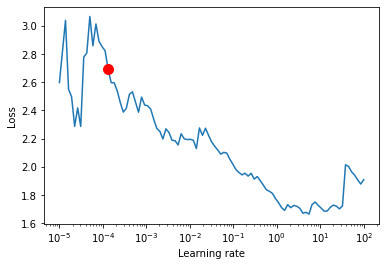

In [36]:
# find optimal learning rate
# remove logging and artificial epoch size
tft.hparams.log_interval = -1
tft.hparams.log_val_interval = -1
trainer.limit_train_batches = 1.0
# run learning rate finder
res = trainer.tuner.lr_find(
    tft, train_dataloader=train_dataloader, val_dataloaders=val_dataloader, min_lr=1e-5, max_lr=1e2
)
print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()
tft.hparams.learning_rate = res.suggestion()

In [37]:
trainer.fit(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
)

C:\Users\kishor.kukreja\anaconda3\envs\virtual_Aes\lib\site-packages\pytorch_lightning\trainer\trainer.py:732: LightningDeprecationWarning: `trainer.fit(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.fit(train_dataloaders)` instead. HINT: added 's'
  rank_zero_deprecation(

    | Name                                                                                              | Type                            | Params
--------------------------------------------------------------------------------------------------------------------------------------------------------
0   | loss                                                                                              | QuantileLoss                    | 0     
1   | logging_metrics                                                                                   | ModuleList                      | 0     
2   | logging_metrics.0                                                                        

Epoch 0:  98%|█████████████████████████▌| 3431/3490 [09:18<00:09,  6.15it/s, loss=1.15, v_num=2, train_loss_step=0.422]
Validating: 0it [00:00, ?it/s]
Epoch 0: 100%|██████████| 3490/3490 [09:21<00:00,  6.21it/s, loss=1.15, v_num=2, train_loss_step=0.422, val_loss=2.850]
Epoch 1:  98%|▉| 3432/3490 [12:00<00:12,  4.76it/s, loss=0.918, v_num=2, train_loss_step=0.209, val_loss=2.850, train_l
Validating: 0it [00:00, ?it/s]
Validating:   2%|█▏                                                                     | 1/59 [00:00<00:09,  5.85it/s]
Epoch 1:  98%|▉| 3435/3490 [12:01<00:11,  4.76it/s, loss=0.918, v_num=2, train_loss_step=0.209, val_loss=2.850, train_l
Validating:   7%|████▊                                                                  | 4/59 [00:00<00:06,  9.00it/s]
Epoch 1:  99%|▉| 3438/3490 [12:01<00:10,  4.77it/s, loss=0.918, v_num=2, train_loss_step=0.209, val_loss=2.850, train_l
Epoch 1:  99%|▉| 3441/3490 [12:01<00:10,  4.77it/s, loss=0.918, v_num=2, train_loss_step=0.209, va

Epoch 1: 100%|▉| 3480/3490 [12:06<00:02,  4.79it/s, loss=0.918, v_num=2, train_loss_step=0.209, val_loss=2.850, train_l
Epoch 1: 100%|▉| 3483/3490 [12:06<00:01,  4.80it/s, loss=0.918, v_num=2, train_loss_step=0.209, val_loss=2.850, train_l
Validating:  88%|█████████████████████████████████████████████████████████████▋        | 52/59 [00:05<00:00, 10.28it/s]
Epoch 1: 100%|▉| 3486/3490 [12:06<00:00,  4.80it/s, loss=0.918, v_num=2, train_loss_step=0.209, val_loss=2.850, train_l
Epoch 1: 100%|▉| 3489/3490 [12:06<00:00,  4.80it/s, loss=0.918, v_num=2, train_loss_step=0.209, val_loss=2.850, train_l
Epoch 1: 100%|█| 3490/3490 [12:06<00:00,  4.80it/s, loss=0.918, v_num=2, train_loss_step=0.209, val_loss=2.600, train_l
Epoch 1: 100%|█| 3490/3490 [12:07<00:00,  4.80it/s, loss=0.918, v_num=2, train_loss_step=0.209, val_loss=2.600, train_l


In [38]:
### Error calculation

In [39]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [40]:
actuals = torch.cat([y for x,(y,weight) in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)
act = actuals.numpy()
pred = predictions.numpy()

In [41]:
(actuals - predictions).abs().mean().item()

6.519962787628174

In [42]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mean_absolute_percentage_error(act,pred)

nan

## Prediction for Future 13 weeks

In [45]:
data.tail()

,PRODUCT_ID,CHANNEL,COUNTRY,WEEK_KEY,CURRENT_PRICE,SALES_VOLUME,WEEK,YEAR,PRODUCT_SEASON,PRODUCT_GROUP,PRODUCT_SUBGROUP,PRODUCT_CLASS,PRODUCT_SUBCLASS,ORIGINAL_PRICE,PREVIOUS_PRICE,WEEK_SIN365_1,WEEK_COS365_1,WEEK_SIN365_2,WEEK_COS365_2,PRICE_CHANGE_WRT_PREVIOUS,PRICE_CHANGE_WRT_ORIGINAL,WEEK_OF_MONTH,IS_MONTH_START,IS_MONTH_END,MONTH,IS_YEAR_START,IS_YEAR_END,IS_QUARTER_START,IS_QUARTER_END,ROLLING_WEEK
111655,feffc058,Online,B,201605,13.586,0.0,5,2016,L,26387251,c3567a18,1ed9f279,6797d7af,13.586,13.586,0.568065,0.822984,0.935016,0.354605,0.0,0.0,1,1,0,2,1,0,0,0,56
111656,feffc058,Online,B,201606,13.586,0.0,6,2016,L,26387251,c3567a18,1ed9f279,6797d7af,13.586,13.586,0.663123,0.748511,0.992709,0.120537,0.0,0.0,2,0,0,2,1,0,0,0,57
111657,feffc058,Online,B,201607,13.586,0.0,7,2016,L,26387251,c3567a18,1ed9f279,6797d7af,13.586,13.586,0.748511,0.663123,0.992709,-0.120537,0.0,0.0,3,0,0,2,1,0,0,0,58
111658,feffc058,Online,B,201608,13.586,0.0,8,2016,L,26387251,c3567a18,1ed9f279,6797d7af,13.586,13.586,0.822984,0.568065,0.935016,-0.354605,0.0,0.0,4,0,1,2,1,0,0,0,59
111659,feffc058,Online,B,201609,13.586,2.0,9,2016,L,26387251,c3567a18,1ed9f279,6797d7af,13.586,13.586,0.885456,0.464723,0.822984,-0.568065,0.0,0.0,5,0,1,2,1,0,0,0,60


In [56]:
start_week = data.WEEK.max()
start_week
start_year= data.YEAR.max()
start_year
start_week_key= data.WEEK_KEY.max()
start_week_key

201609

In [57]:
weeks = list(np.arange(start+1, start+13))
weeks_key = list(np.arange(start_week_key+1, start_week_key+13))
years = list([start_year]*13)
weeks_key

[201610,
 201611,
 201612,
 201613,
 201614,
 201615,
 201616,
 201617,
 201618,
 201619,
 201620,
 201621]

In [ ]:

data[['start_date','end_date']]=data.apply(lambda x : get_start_end_dates(x['year'],x['week']),axis=1,result_type="expand")
data['week_of_month']=data.apply(lambda x: get_week_of_month(x['start_date']),axis=1)

df_sales_price['is_month_start']=df_sales_price.apply(lambda x: 1 if x['week_of_month']==1 else 0,axis=1)
df_sales_price['is_month_end']=df_sales_price.apply(lambda x: 1 if x['week_of_month']>=4 else 0,axis=1)
df_sales_price['month']=df_sales_price['start_date'].dt.month
df_sales_price['is_year_start']=df_sales_price.apply(lambda x: 1 if x['month']>=2 else 0,axis=1)
df_sales_price['is_year_end']=df_sales_price.apply(lambda x: 1 if x['month']>=11 else 0,axis=1)
df_sales_price['is_quarter_start']=df_sales_price.apply(lambda x: 1 if (x['month']==1 or x['month']==4 or x['month']==7 or x['month']==10 ) and x['week_of_month']==1 else 0,axis=1)
df_sales_price['is_quarter_end']=df_sales_price.apply(lambda x: 1 if (x['month']==3 or x['month']==6 or x['month']==9 or x['month']==12 ) and x['week_of_month']>=1 else 0,axis=1)

df_sales_price['week_sin365_1'] = np.sin(2*np.pi*df_sales_price['week']/52)
df_sales_price['week_cos365_1'] = np.cos(2*np.pi*df_sales_price['week']/52)
df_sales_price['week_sin365_2'] = np.sin(4*np.pi*df_sales_price['week']/52)
df_sales_price['week_cos365_2'] = np.cos(4*np.pi*df_sales_price['week']/52)


df_price["current_price"] = df_price.groupby(["product_id", "channel","country"])['current_price'].transform(lambda x: x.bfill())
df_price["current_price"] = df_price.groupby(["product_id", "channel","country"])['current_price'].transform(lambda x: x.ffill())
df_price["current_price"] = df_price["current_price"].fillna(0)


df_price["previous_price"] = df_price.groupby(["product_id", "channel","country"])['previous_price'].transform(lambda x: x.bfill())
df_price["previous_price"] = df_price.groupby(["product_id", "channel","country"])['previous_price'].transform(lambda x: x.ffill())
df_price["previous_price"] = df_price["previous_price"].fillna(0)


df_price["original_price"] = df_price.groupby(["product_id", "channel","country"])['original_price'].transform(lambda x: x.bfill())
df_price["original_price"] = df_price.groupby(["product_id", "channel","country"])['original_price'].transform(lambda x: x.ffill())
df_price["original_price"] = df_price["original_price"].fillna(0)


df_sales_price['price_change_wrt_previous']=df_sales_price.apply(lambda x: ((x['current_price_x']-x['previous_price'])/(x['previous_price']+epsilon))*100,axis=1)

df_sales_price['price_change_wrt_original']=df_sales_price.apply(lambda x: ((x['current_price_x']-x['original_price'])/(x['original_price']+epsilon))*100,axis=1)

In [ ]:
df_future = pd.DataFrame()
df_future['PRODUCT_ID'] = data.PRODUCT_ID.unique()
df_future['CHANNEL'] = data.CHANNEL.unique()
df_future['COUNTRY'] = data.COUNTRY.unique()
Weeks = list(np.arange(start+1, start+13))
df_future['weekday'] = [Weeks for _ in range(len(df_future))]
df_future = df_future.explode('weekday').reset_index(drop = True)
df_future['year'] = 2021